In [1]:
#This code creates one dataframe which contains all roads and lrps from the RMMS file as they are currently all separate files. It does this by creating a for loop which runs over all the files in RMMS and picks out the files which have .lrps.htm in the name as these are the files we are interested in. It then saves it as a csv file called combined_lrps.csv to use for further analysis.  

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

path = 'RMMS'
files = [f for f in os.listdir(path) if f.endswith('.lrps.htm')]
dfs = []

#Loop through each file in RMMS
for file in files:
    tables = pd.read_html(os.path.join(path, file))

    df = pd.concat(tables)

    df = df.iloc[9:].reset_index(drop=True)

    df.columns = df.iloc[0]

    df = df.iloc[1:].reset_index(drop=True)

    df = df.iloc[:, 1:-1]

    #Add new column for road number
    road_number = file.split('.')[0]  
    df['road_number'] = road_number

    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df.to_csv('combined_lrps.csv', index=False)


In [3]:
#Check the traffic dataframe
traffic_df = pd.read_csv('traffic.csv')
traffic_df.head()

road                               name     LRP  Offset  Chainage LRP_end  \
0   N1       Jatrabari - Int.with Z1101      LRPS       0     0.000    LRPS   
1   N1  Int.with Z1101 - Signboard  R111     LRPS     822     0.822    LRPS   
2   N1         Signboard - Shimrail R110     LRPS    4175     4.175    LRPS   
3   N1            Shimrail - Katchpur N2     LRPS    7181     7.181  LRP009   
4   N1          Katchpur - Madanpur N105   LRP009     260     8.763  LRP012   

   Óffset_end  Chainage_end   (Km) Heavy Truck  ...     Car Auto Rickshaw  \
0         822         0.822  0.822       531.0  ...  2229.5        2744.0   
1        4175         4.175  3.353       531.0  ...  2229.5        2744.0   
2        7181         7.181  3.006        88.0  ...  1649.5        2211.5   
3         260         8.763  1.582       163.5  ...  1763.5        2923.5   
4         439        11.936  3.173       163.5  ...  1842.0        3117.0   

  Motor Cycle Bi-Cycle Cycle Rickshaw Cart Motorized Non Motorized Total AADT  \
0       417.0    222.5          988.5  0.0   19236.0        1211.0    20447.0   
1       417.0    222.5          988.5  0.0   19236.0        1211.0    20447.0   
2      1061.0     73.5         1169.0  0.0   15866.5        1242.5    17109.0   
3      1152.5    364.0         1304.0  0.0   15998.5        1668.0    17666.5   
4      1148.5    364.0         1304.0  0.0   22566.0        1668.0    24234.0   

    (AADT)  
0  20447.0  
1  20447.0  
2  17109.0  
3  17666.5  
4  24234.0  

[5 rows x 26 columns]

In [4]:
#Renaming columns so it is more clear what data they represent.
traffic_df = traffic_df.rename(columns = { 'LRP':'LRP Start', 'Offset': 'Offset Start', 'Chainage':'Chainage Start', 'LRP.1':'LRP End', 'Offset.1': 'Offset End', 'Chainage.1':'Chainage End'})
print(traffic_df.shape)


(1993, 26)


In [5]:
# Combining the different dataframes into one so we have the lat/lon values combined with the AADT values so we can calculate the different economic values for the road parts.  
latlonload = pd.merge(traffic_df, combined_df, left_on=['LRP Start','road'], right_on=['LRP No', 'road_number'] )

In [6]:
#When merging we got 3 rows of each entry, we have dropped the duplicates below to ensure we do not get double entries.
latlonload = latlonload.drop_duplicates()

In [7]:
#To calculate the economic value of a roadpart, we have to assign economic value to different vehicle types. Afterwards we will multiply these values with the amount of sightings on each road to compute the economic value of a road. The logic behind the values is that for example trucks are able to carry a lot of goods, busses a lot of people and smaller vehicles are more individual focussed, hence the smaller economic impact. It should be noted that these are all estimates as we were unable to find research on the marginal economic impact of these vehicle types. Furthermore this code drops all the 'NS' columns which do not contain any data. The is_float definition is used to ensure that we can multiply the columns so they do not given an error. 

economic_value_vehicles = {'Heavy Truck':10, 'Medium Truck': 8, 'Small Truck':7, 'Large Bus':7, 'Medium Bus':6,
                           'Micro Bus':5, 'Utility':3, 'Car':3, 'Auto Rickshaw':2, 'Motor Cycle': 1,
                           'Bi-Cycle':0.5, 'Cycle Rickshaw':1, 'Cart':1}

latlonload = latlonload[~latlonload.apply(lambda row: (row == 'NS').any(), axis=1)]

economic_df = latlonload.loc[:, 'Heavy Truck':'Cart']

def is_float(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

for col in economic_df.columns:
    non_numeric_values = economic_df[col][~economic_df[col].apply(is_float)]
    if not non_numeric_values.empty:
        print(f"Non-numeric values in column '{col}':")
        print(non_numeric_values)




In [8]:
# Converting values to floats to ensure no errors occur due to wrong type data, afterwards a new column is appended containing the economic value of a road. 
economic_df = economic_df.astype(float)

latlonload['EVV'] = economic_df.apply(lambda row: sum(row[col] * economic_value_vehicles[col] for col in economic_df.columns if col in economic_value_vehicles), axis=1)


road                                               name LRP Start  \
2328  Z8806      Dumki(int.with Z8044)-Bauphal(int.with Z8910)      LRPS   
2334  Z8806  Kalaiya (Int.with Z8052)-Amragachia(int.with R...    LRP027   
2337  Z8815                                          Amua-Safa      LRPS   
2340  Z8905  Udypur (Int.with R890) - Tazumuddin (Int.with ...      LRPS   
2343  Z8905            Tazumuddin (Int.with Z8943) - Sikdarhat    LRP003   
2346  Z8909               Char Fession (Int.with R890) - Betua      LRPS   
2349  Z8916        Guingerhat (Int.with R890) - Int.with Z8915      LRPS   
2352  Z8916                  Int.with Z8915 - Daulatkhan Bazar    LRP004   
2355  Z8943  Tazumuddin (Int.with Z8905) - Fakirhat (Int.wi...      LRPS   
2358  Z8943  Fakirhat (Int.with Z8948) - Kungerhat (Int.wit...      LRPS   

      Offset Start  Chainage Start LRP_end  Óffset_end  Chainage_end    (Km)  \
2328          2858           2.858    LRPS       24312        24.312  21.454   
2334          2140          28.656    LRPE           0        86.377  57.721   
2337             0           0.000    LRPS       13057        13.057  13.057   
2340             0           0.000  LRP003       10700        13.000  13.000   
2343         10700          13.000  LRP003       35700        38.000  25.000   
2346             0           0.000  LRP006         952         7.002   7.002   
2349             0           0.000  LRP004        3626         7.626   7.626   
2352          3626           7.626  LRP005        6600        11.591   3.965   
2355             0           0.000    LRPS        6446         6.446   6.446   
2358          6446           6.446    LRPS        8800         8.800   2.354   

     Heavy Truck  ... Total AADT  (AADT)  LRP No Road Chainage LRP TYPE  \
2328         0.0  ...     2242.0  2242.0    LRPS             0   Others   
2334         0.0  ...     1307.0  1307.0  LRP027        26.516  Km Post   
2337         0.0  ...     1941.0  1941.0    LRPS             0   Others   
2340         0.0  ...     1923.0  1923.0    LRPS             0   Others   
2343         0.0  ...     1201.0  1201.0  LRP003           2.3  Km Post   
2346         0.0  ...     3991.0  3991.0    LRPS             0   Others   
2349         0.0  ...     2440.0  2440.0    LRPS             0   Others   
2352         0.0  ...     2440.0  2440.0  LRP004             4  Km Post   
2355         0.0  ...     3083.0  3083.0    LRPS             0   Others   
2358         0.0  ...     3083.0  3083.0    LRPS             0   Others   

                                            Description Latitude Decimal  \
2328  Start of Road from N8 infornt of Patuakhali Sc...       22.4536667   
2334                              Information Not Clear       22.4074722   
2337          Start of road from Amua Bazar ,Zhalokati.         22.35875   
2340  Start of road from R 890 at Udypur (Teenmatha)...       22.4862774   
2343                                Information missing       22.4913886   
2346    Start from R890 at Thana road more char fassion        22.185833   
2349          Start from R890 at Guingerhat Bazar Dhola       22.6254993   
2352                                Information missing       22.6189716   
2355  Start at intersection of Z8905 /BC joint infro...       22.4264438   
2358  Start at intersection of Z8905 /BC joint infro...       22.4264438   

     Longitued Decimal road_number     EVV  
2328        90.3410552       Z8806  4315.0  
2334        90.5713604       Z8806  1463.0  
2337         90.075416       Z8815  2191.0  
2340        90.7690549       Z8905  3764.5  
2343        90.7908052       Z8905  2377.0  
2346          90.76025       Z8909  5192.5  
2349        90.6617222       Z8916  3553.5  
2352        90.6941108       Z8916  3553.5  
2355        90.8494719       Z8943  5651.0  
2358        90.8494719       Z8943  5651.0  

[10 rows x 34 columns]

In [9]:
#renaming the column because of a spelling error 
latlonload = latlonload.rename(columns={'Longitued Decimal':'Longitude Decimal'})


road                                           name LRP Start  \
15     N1                   Madanpur - Langalband Z1061     LRP012   
18     N1        Langalband - Mograpara Chowrasta Z1089     LRP013   
12     N1                      Katchpur - Madanpur N105     LRP009   
297  N303            Churkhai Bazar-Intersection with N3      LRPS   
0      N1                   Jatrabari - Int.with Z1101        LRPS   
3      N1              Int.with Z1101 - Signboard  R111       LRPS   
306  N406  Start form N4 near IT park Gate-int.with R315      LRPS   
312  N407  Korotia(Int.with N408)-Bangra(Int.with Z4012)      LRPS   
105    N1             Barabkunda Z1087-Fouzderhat Z1016     LRP209   
102    N1            Baroirdala Z1086- Barabkunda Z1087     LRP197   

     Offset Start  Chainage Start LRP_end  Óffset_end  Chainage_end    (Km)  \
15            439          11.936  LRP013        3411        15.935   3.999   
18           3411          15.935  LRP013        7520        20.044   4.109   
12            260           8.763  LRP012         439        11.936   3.173   
297             0           0.000    LRPS        1009         1.009   1.009   
0               0           0.000    LRPS         822         0.822   0.822   
3             822           0.822    LRPS        4175         4.175   3.353   
306             0           0.000    LRPS        2802         2.802   2.802   
312             0           0.000    LRPE           0         2.206   2.206   
105           486         206.402  LRP225        6400       228.406  22.004   
102          1120         194.603  LRP209         486       206.402  11.799   

    Heavy Truck  ... Total AADT   (AADT)  LRP No Road Chainage LRP TYPE  \
15        163.5  ...    24234.0  24234.0  LRP012        11.497  Km Post   
18        163.5  ...    24234.0  24234.0  LRP013        12.524  Km Post   
12        163.5  ...    24234.0  24234.0  LRP009         8.503  Km Post   
297       289.0  ...    28352.0  28352.0    LRPS             0   Others   
0         531.0  ...    20447.0  20447.0    LRPS             0   Others   
3         531.0  ...    20447.0  20447.0    LRPS             0   Others   
306        37.0  ...    16456.0  16456.0    LRPS             0   Others   
312        37.0  ...    16456.0  16456.0    LRPS             0   Others   
105      1101.5  ...    15291.0  15291.0  LRP209       205.916  Km Post   
102      1101.5  ...    15291.0  15291.0  LRP197       193.483  Km Post   

                                           Description Latitude Decimal  \
15                     Chittagong 248 km,Comilla 81 km       23.6918052   
18                            Ctg 247 km,Comilla 80 km       23.6865274   
12                     Chittagong 251 km,Comilla 84 km       23.7050278   
297      The Road starts from N3 before Churkhai Bazar       24.6712771   
0    Start of Road after Jatrabari Flyover infront ...       23.7060278   
3    Start of Road after Jatrabari Flyover infront ...       23.7060278   
306          The road starts from N4 near IT park Gate       23.9894163   
312         The road starts from N408 at Karatia Bazar       24.2223049   
105                                       Info.Missing        22.584583   
102                           Ctg 48 km,Sitakanda 8 km       22.6825549   

    Longitude Decimal road_number        EVV  
15         90.5426108          N1  126461.00  
18         90.5504167          N1  126461.00  
12         90.5193327          N1  126461.00  
297        90.4035833        N303  124984.00  
0           90.443333          N1  111888.75  
3           90.443333          N1  111888.75  
306        90.2247493        N406   95484.50  
312        89.9781104        N407   95484.50  
105        91.6780827          N1   89902.50  
102        91.6241938          N1   89902.50  

[10 rows x 34 columns]

In [10]:
#Checking the EVV distribution to check what the vmax should be for good visualisation of the roads. This seems to be +- 55000 as this is the 75th percentile. 
latlonload.describe()


Offset Start  Chainage Start    Óffset_end  Chainage_end        (Km)  \
count    662.000000      662.000000    662.000000    662.000000  662.000000   
mean    1181.170695       53.736698   2739.043807     63.978293   10.241595   
std     3050.733142       99.540647   5069.869258     99.220063    9.236668   
min        0.000000        0.000000      0.000000      0.400000    0.326000   
25%        0.000000        0.000000    376.500000      9.396500    3.310750   
50%      267.500000        6.930500    924.500000     22.511000    7.687500   
75%      955.250000       51.203750   2635.250000     62.865250   14.278750   
max    38564.000000      495.369000  51184.000000    526.033000   61.699000   

                 EVV  
count     662.000000  
mean    20090.442221  
std     22556.455612  
min       662.000000  
25%      5289.500000  
50%     11193.250000  
75%     25481.375000  
max    126461.000000

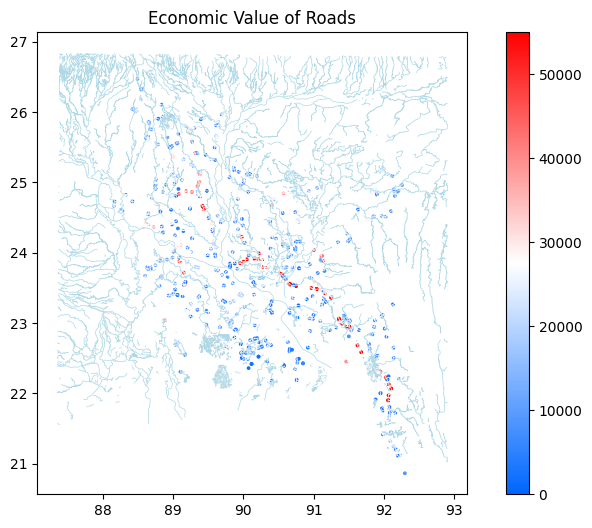

In [11]:
# Loading the shapefiles from the roads and waterways to display them in our map together with the EVV values of the roads. This will give us an understanding of economically important roads. The rivers are used for sense of where the roads are as OSM and other ways did not give the desired backgrounds. One point with lat/lon 0/0 was removed as this was cause the map to fail loading. 

roads = gpd.read_file("osm/roads.shp")
waterways = gpd.read_file("osm/waterways.shp")

latlonload['Latitude Decimal'] = pd.to_numeric(latlonload['Latitude Decimal'], errors='coerce')
latlonload['Longitude Decimal'] = pd.to_numeric(latlonload['Longitude Decimal'], errors='coerce')

tolerance = 0.01
latlonload = latlonload[
    (latlonload['Latitude Decimal'].abs() > tolerance) &
    (latlonload['Longitude Decimal'].abs() > tolerance)
]

gdf = gpd.GeoDataFrame(latlonload, geometry=gpd.points_from_xy(latlonload['Longitude Decimal'], latlonload['Latitude Decimal']))
cmap = LinearSegmentedColormap.from_list('evv', ['#0066ff', '#ffffff', '#ff0000'])
ax = roads.plot(color='white', edgecolor='black', figsize=(10, 6), linewidth=0.5)
waterways.plot(ax=ax, color='lightblue', linewidth=0.5)
gdf.plot(ax=ax, marker='o', markersize=3, column='EVV', cmap=cmap, legend=True, vmin=0, vmax=55000)

plt.title('Economic Value of Roads')
plt.show()


In [12]:
# saving the dataframe for further use
latlonload.to_csv('latlonloads.csv')


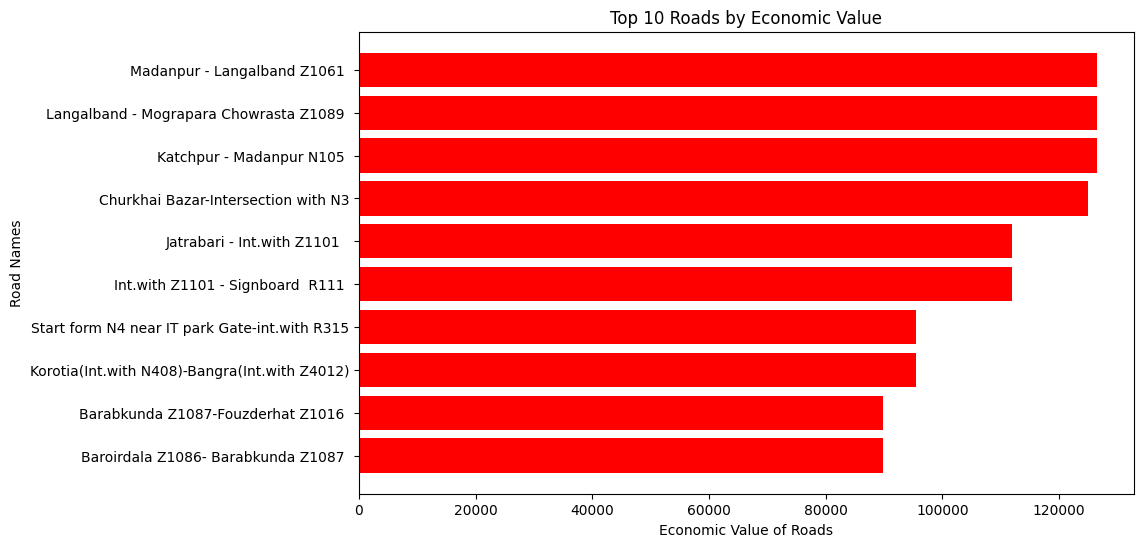

In [13]:
# Sort the DataFrame based on 'EVV' column in descending order to show the top 10 EVV contributing road parts. 
sorted_latlonload = latlonload.sort_values('EVV', ascending=False)
top_n = 10
top_n_df = sorted_latlonload.head(top_n)
road_names = top_n_df['name']
evv_values = top_n_df['EVV']

plt.figure(figsize=(10, 6))
plt.barh(road_names, evv_values, color='red')
plt.xlabel('Economic Value of Roads')
plt.ylabel('Road Names')
plt.title(f'Top {top_n} Roads by Economic Value')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest-ranking road at the top
plt.show()


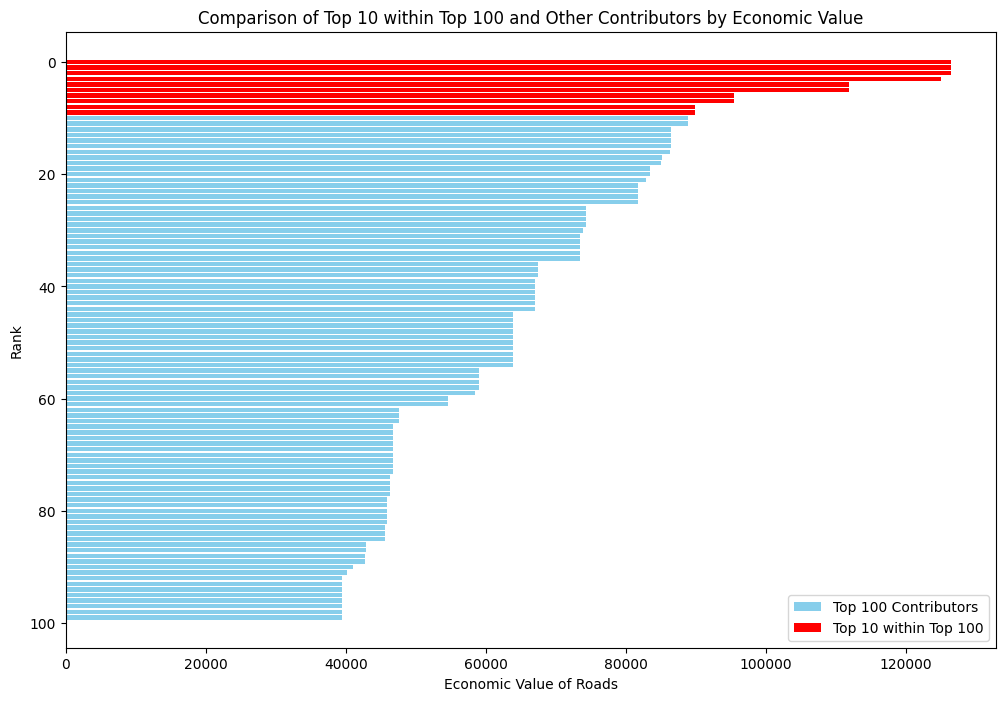

In [14]:
# Get the top 100 roads and afterwards plotting the top 10 to show contrast in road contributions. 
top_100_df = sorted_latlonload.head(100)

top_10_within_100 = top_100_df.head(10)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_100_df)), top_100_df['EVV'], color='skyblue', label='Top 100 Contributors')
plt.barh(range(len(top_10_within_100)), top_10_within_100['EVV'], color='red', label='Top 10 within Top 100')

plt.xlabel('Economic Value of Roads')
plt.ylabel('Rank')
plt.title('Comparison of Top 10 within Top 100 and Other Contributors by Economic Value')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to display the highest-ranking road at the top
plt.show()


In [17]:
#Saving the top100 dataframe for further analysis
top_100_df['name'].to_csv('../data/processed/Criticality100.csv', index=False)

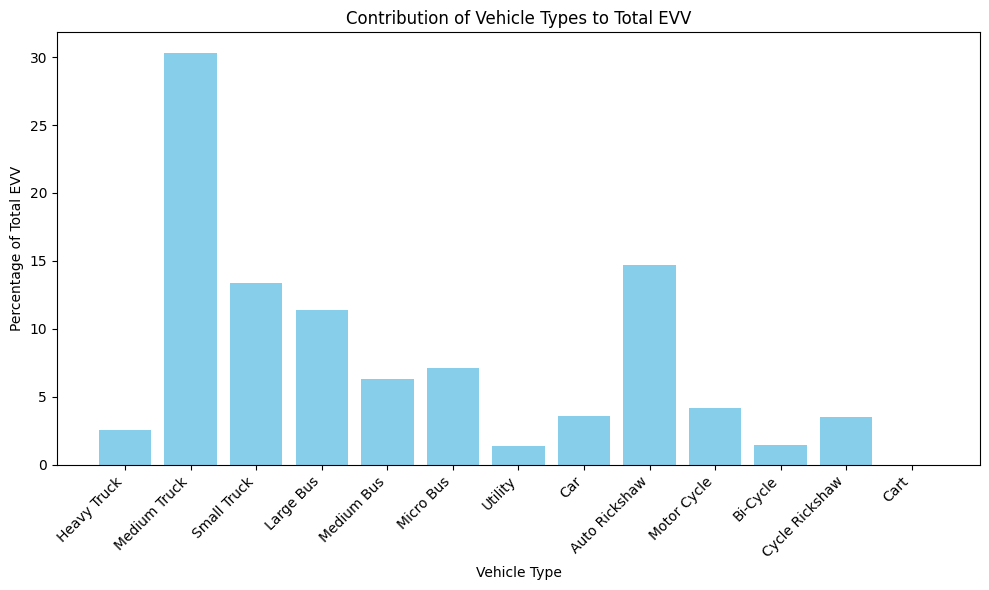

In [15]:
#Here we calculate the partial contributions to the total EVV of each vehicle, this gives insight as to what vehicles contribute most to the economic values of the roads. 
latlonload = latlonload.apply(pd.to_numeric, errors='coerce')

total_evv_per_vehicle = {}
for vehicle, value in economic_value_vehicles.items():
    total_evv_per_vehicle[vehicle] = latlonload[vehicle].sum() * value

df_total_evv_per_vehicle = pd.DataFrame(total_evv_per_vehicle.items(), columns=['Vehicle', 'Total EVV'])

total_evv = df_total_evv_per_vehicle['Total EVV'].sum()

df_total_evv_per_vehicle['Percentage'] = (df_total_evv_per_vehicle['Total EVV'] / total_evv) * 100

plt.figure(figsize=(10, 6))
plt.bar(df_total_evv_per_vehicle['Vehicle'], df_total_evv_per_vehicle['Percentage'], color='skyblue')
plt.xlabel('Vehicle Type')
plt.ylabel('Percentage of Total EVV')
plt.title('Contribution of Vehicle Types to Total EVV')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
